In [1]:
# The MIT License (MIT) Copyright (c) 2024 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/29_VAE.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# VAE

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

torch.__version__

'2.5.1+cu121'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 128

train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

In [5]:
len(train_loader.dataset)

60000

In [6]:
test_batch, test_labels = next(iter(train_loader))
test_batch.shape, test_labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

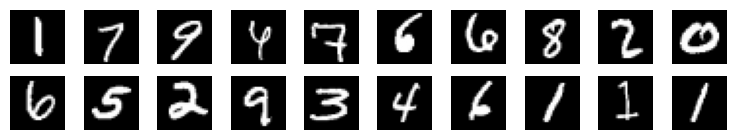

In [7]:
def plot_batch(images):
    fig, axes = plt.subplots(2, 10, figsize=(7.5, 1.5))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

n = 20
batch_images = test_batch[:n]

plot_batch(batch_images)

## 2.- Modelo

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, image_channels=1, z_dim=64, z_ch=128):
        super(VAE, self).__init__()
        self.z_ch = z_ch
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), # output is 7x7
        )
        self.encoder_fc =  nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, z_dim)
        self.fc_log_var = nn.Linear(256, z_dim)

        self.decoder_fc = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.z_ch*7*7),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(self.z_ch, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        conv_output = self.encoder_conv(x)
        conv_output = conv_output.view(conv_output.size(0), -1)
        conv_output = self.encoder_fc(conv_output) 
        mu = self.fc_mu(conv_output)
        log_var = self.fc_log_var(conv_output)
        # Clamp log_var for numerical stability
        log_var = torch.clamp(log_var, min=-10, max=10)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        fc_output = self.decoder_fc(z)
        fc_output = fc_output.view(fc_output.shape[0], self.z_ch, 7, 7)
        reconstructed = self.decoder_conv(fc_output)
        return reconstructed
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var
        
        
z_dim = 64  
vae = VAE(z_dim=z_dim)
rec_batch, mu, log_var = vae(test_batch)
rec_batch.shape

torch.Size([128, 1, 28, 28])

## 3.- Entrenamiento

In [9]:
from torch import optim

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [11]:
vae.to(device)

VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder_fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=64, bias=True)
  (decoder_fc): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_fe

Epoch 0, Loss: 0.1231, Recon: 0.1231, KL: 6.8567, Beta: 0.000000

Reconstruction samples at epoch 0:


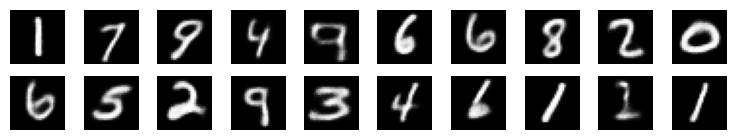

Generated samples at epoch 0:


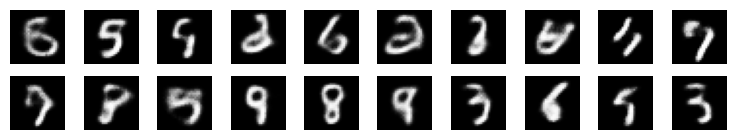

Epoch 5, Loss: 0.0961, Recon: 0.0901, KL: 1.3907, Beta: 0.004375
Epoch 10, Loss: 0.0970, Recon: 0.0892, KL: 0.8844, Beta: 0.008750

Reconstruction samples at epoch 10:


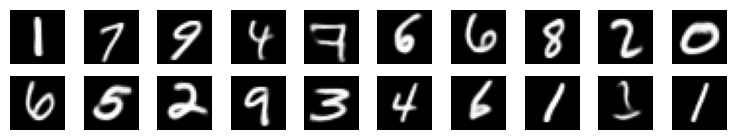

Generated samples at epoch 10:


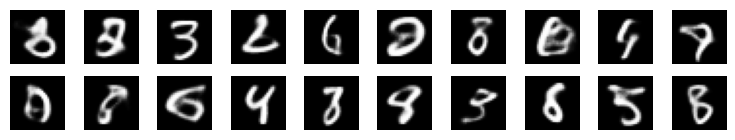

Epoch 15, Loss: 0.0996, Recon: 0.0899, KL: 0.7408, Beta: 0.013125
Epoch 20, Loss: 0.1040, Recon: 0.0918, KL: 0.6994, Beta: 0.017500

Reconstruction samples at epoch 20:


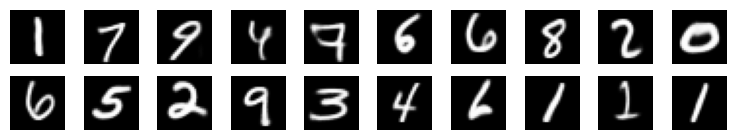

Generated samples at epoch 20:


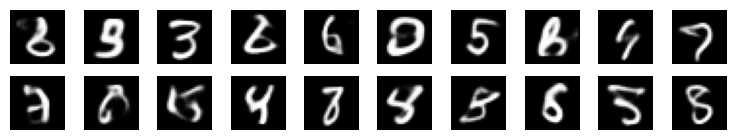

Epoch 25, Loss: 0.1064, Recon: 0.0928, KL: 0.6243, Beta: 0.021875
Epoch 30, Loss: 0.1012, Recon: 0.0860, KL: 0.5775, Beta: 0.026250

Reconstruction samples at epoch 30:


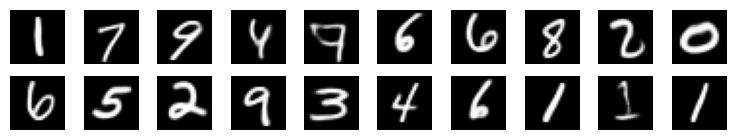

Generated samples at epoch 30:


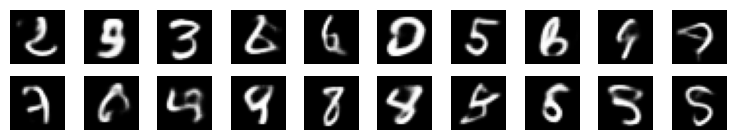

Epoch 35, Loss: 0.1063, Recon: 0.0898, KL: 0.5387, Beta: 0.030625
Epoch 40, Loss: 0.1112, Recon: 0.0930, KL: 0.5221, Beta: 0.035000

Reconstruction samples at epoch 40:


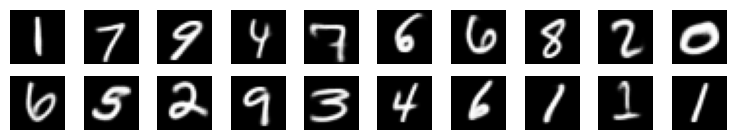

Generated samples at epoch 40:


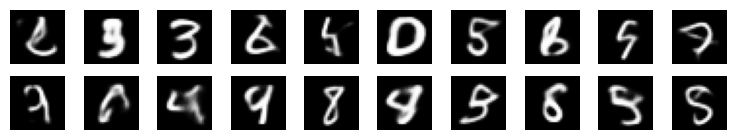

Epoch 45, Loss: 0.1072, Recon: 0.0875, KL: 0.4987, Beta: 0.039375
Epoch 50, Loss: 0.1155, Recon: 0.0944, KL: 0.4833, Beta: 0.043750

Reconstruction samples at epoch 50:


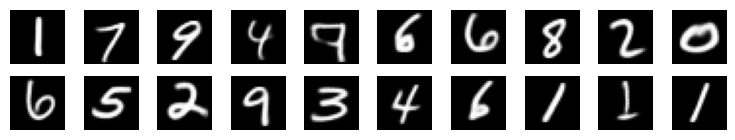

Generated samples at epoch 50:


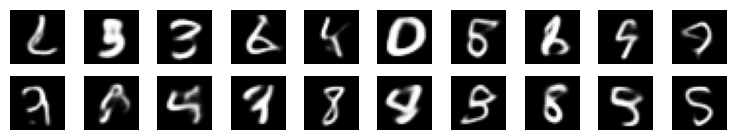

Epoch 55, Loss: 0.1133, Recon: 0.0907, KL: 0.4684, Beta: 0.048125
Epoch 60, Loss: 0.1172, Recon: 0.0947, KL: 0.4285, Beta: 0.052500

Reconstruction samples at epoch 60:


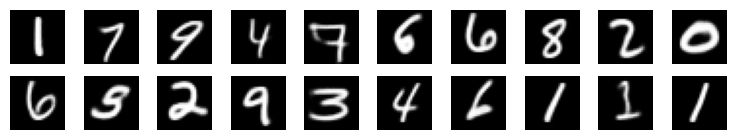

Generated samples at epoch 60:


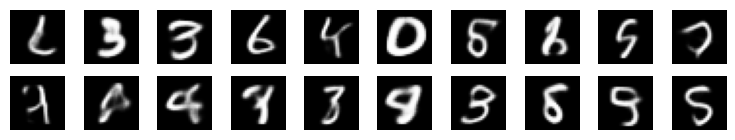

Epoch 65, Loss: 0.1207, Recon: 0.0961, KL: 0.4329, Beta: 0.056875
Epoch 70, Loss: 0.1252, Recon: 0.0994, KL: 0.4218, Beta: 0.061250

Reconstruction samples at epoch 70:


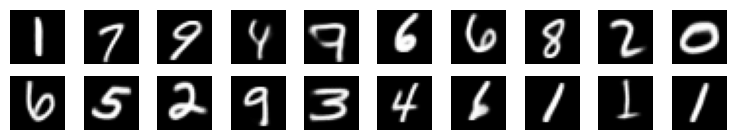

Generated samples at epoch 70:


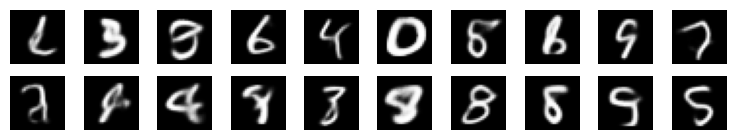

In [ ]:
lr = 1e-3
num_epochs = 80  
beta_start = 0.0
beta_end = 0.07 
beta = beta_start
#beta = 0.01
reconstruction_loss = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-5)

epoch_inter = 10
z_test = torch.randn(n, z_dim, device=device)

for epoch in range(num_epochs + 1):
    # Beta annealing: gradually increase beta 
    beta = beta_start + (beta_end - beta_start) * (epoch / num_epochs)
    
    for images, _ in train_loader:
        images = images.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        reconstructed, mu, log_var = vae(images)
        # Reconstruction loss (mean over batch and pixels)
        recon_loss = reconstruction_loss(reconstructed, images)
        # KL divergence (mean over batch)
        kl_div = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        # Total loss with beta weighting
        loss = recon_loss + beta * kl_div

        loss.backward()
        optimizer.step()

    if epoch % 5 == 0 or epoch == num_epochs:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, KL: {kl_div.item():.4f}, Beta: {beta:.6f}')

    if epoch % epoch_inter == 0:
        with torch.no_grad():
            rec_batch, mu, log_var = vae(test_batch.to(device))
            print(f"\nReconstruction samples at epoch {epoch}:")
            plot_batch(rec_batch[:n].detach().cpu())
            sample = vae.decode(z_test)
            print(f"Generated samples at epoch {epoch}:")
            plot_batch(sample.detach().cpu())